In [1]:
import numpy as np
import gymnasium as gym
from gymnasium import spaces
import cantera as ct
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.callbacks import BaseCallback
import time
import matplotlib.pyplot as plt
import SundialsPy as SP

# Import your utility functions
from utils import create_solver, get_initial_state


In [ ]:
class IntegratorSwitchingEnv(gym.Env):
    """RL Environment for combustion integrator switching"""
    
    def __init__(self, mechanism_file='h2o2.yaml', 
                 temp_range=(800, 1200), phi_range=(0.5, 2.0), 
                 time_range=(1e-3, 2e-2), timestep=1e-6, super_steps=100,
                 fuel='H2', oxidizer='O2:0.21, N2:0.79', pressure=ct.one_atm,
                 small_phi_range=(1e-10, 1e-5), large_phi_range=(10, 1e6),
                 pressure_factor_range=(0.1, 10.0)):
        
        super().__init__()
        
        # Simulation parameter ranges
        self.mechanism_file = mechanism_file
        self.temp_range = temp_range
        self.phi_range = phi_range
        self.time_range = time_range
        self.timestep = timestep
        self.super_steps = super_steps
        self.fuel = fuel
        self.oxidizer = oxidizer
        self.pressure = pressure
        self.small_phi_range = small_phi_range
        self.large_phi_range = large_phi_range
        self.pressure_factor_range = pressure_factor_range
        # Current episode parameters (will be randomized)
        self.current_temp = None
        self.current_phi = None
        self.current_total_time = None
        self.current_n_episodes = None
        
        # Action space: 6 actions (2 solvers × 3 tolerance levels)
        self.action_space = spaces.Discrete(15)
        self.actions = [
            
            # ('cvode_adams', 1e-6, 1e-8, None),   # BDF low tolerance
            # ('cvode_adams', 1e-8, 1e-10, None),  # BDF medium tolerance  
            # ('cvode_adams', 1e-10, 1e-12, None), # BDF high tolerance
            # ('cpp_rk23', 1e-6, 1e-8, None),    # C++ low tolerance
            # ('cpp_rk23', 1e-8, 1e-10, None),   # C++ medium tolerance
            # ('cpp_rk23', 1e-10, 1e-12, None),  # C++ high tolerance
            ('arkode_erk', 1e-6, 1e-8, SP.arkode.ButcherTable.HEUN_EULER_2_1_2),  # Heun low tolerance
            ('arkode_erk', 1e-8, 1e-10, SP.arkode.ButcherTable.HEUN_EULER_2_1_2),  # Heun medium tolerance
            ('arkode_erk', 1e-10, 1e-12, SP.arkode.ButcherTable.HEUN_EULER_2_1_2),  # Heun high tolerance
            ('cvode_bdf', 1e-6, 1e-8, None),   # BDF low tolerance
            ('cvode_bdf', 1e-8, 1e-10, None),  # BDF medium tolerance  
            ('cvode_bdf', 1e-10, 1e-12, None), # BDF high tolerance
            # ('arkode_erk', 1e-6, 1e-8, SP.arkode.ButcherTable.BOGACKI_SHAMPINE_4_2_3),  # Heun low tolerance
            # ('arkode_erk', 1e-8, 1e-10, SP.arkode.ButcherTable.BOGACKI_SHAMPINE_4_2_3),  # Heun medium tolerance
            # ('arkode_erk', 1e-10, 1e-12, SP.arkode.ButcherTable.BOGACKI_SHAMPINE_4_2_3),  # Heun high tolerance
            # ('arkode_dirk', 1e-6, 1e-8, SP.arkode.ButcherTable.TRBDF2_3_3_2),  # Heun low tolerance
            # ('arkode_dirk', 1e-8, 1e-10, SP.arkode.ButcherTable.TRBDF2_3_3_2),  # Heun medium tolerance
            # ('arkode_dirk', 1e-10, 1e-12, SP.arkode.ButcherTable.TRBDF2_3_3_2)  # Heun high tolerance
        ]
        
        # State space: temperature + key species (O, H, OH, H2O, O2, H2)
        self.state_species = ['O', 'H', 'OH', 'H2O', 'O2', 'H2']
        self.observation_space = spaces.Box(
            low=-50, high=50, shape=(7,), dtype=np.float32  # 1 temp + 6 species
        )
        
        self.reset()
    
    def _setup_chemistry(self, temperature, end_time, phi, pressure_factor):
        """Initialize chemistry with randomized parameters"""
        # Randomize parameters for this episode
        if temperature is None:
            self.current_temp = np.random.uniform(*self.temp_range)
        else:
            self.current_temp = temperature
        if phi is None:
            if np.random.uniform() < 0.25:
                self.current_phi = np.random.uniform(*self.small_phi_range)
            elif np.random.uniform() < 0.5:
                self.current_phi = np.random.uniform(*self.large_phi_range)
            else:
                self.current_phi = np.random.uniform(*self.phi_range)
        else:
            self.current_phi = phi
        if pressure_factor is None:
            if np.random.uniform() < 0.5:
                self.current_pressure_factor = np.random.uniform(*self.pressure_factor_range)
            else:
                self.current_pressure_factor = 1
        else:
            self.current_pressure_factor = pressure_factor
        
        if end_time is None:
            self.current_total_time = np.random.uniform(*self.time_range)
        else:
            self.current_total_time = end_time
        self.current_n_episodes = int(self.current_total_time / self.timestep) // self.super_steps
        
        # Setup separate gas objects for reference and RL
        self.gas_ref = ct.Solution(self.mechanism_file)
        self.gas_ref.set_equivalence_ratio(self.current_phi, self.fuel, self.oxidizer)
        self.gas_ref.TP = self.current_temp, self.pressure * self.current_pressure_factor
        
        self.gas_rl = ct.Solution(self.mechanism_file)
        self.gas_rl.set_equivalence_ratio(self.current_phi, self.fuel, self.oxidizer)
        self.gas_rl.TP = self.current_temp, self.pressure * self.current_pressure_factor
        
        # Get species indices
        self.species_indices = {spec: self.gas_ref.species_index(spec) 
                               for spec in self.state_species}
        
        # Run reference trajectory for this episode
        self._run_reference_trajectory()
    
    def _run_reference_trajectory(self):
        """Run complete reference trajectory with Cantera using current parameters"""
        reactor = ct.IdealGasConstPressureReactor(self.gas_ref)
        sim = ct.ReactorNet([reactor])
        sim.rtol = 1e-12
        sim.atol = 1e-14
        
        self.ref_states = []
        self.ref_times = []
        
        # Store initial state
        state = np.hstack([reactor.T, reactor.thermo.Y])
        self.ref_states.append(state)
        self.ref_times.append(0.0)
        
        # Store every substep for detailed comparison
        current_time = 0.0
        total_substeps = self.current_n_episodes * self.super_steps
        
        for substep in range(total_substeps):
            current_time += self.timestep
            sim.advance(current_time)
            
            state = np.hstack([reactor.T, reactor.thermo.Y])
            self.ref_states.append(state)
            self.ref_times.append(current_time)
        
        self.ref_states = np.array(self.ref_states)
        self.ref_times = np.array(self.ref_times)
    
    def _get_observation(self, state):
        """Transform state to observation"""
        temp = state[0]
        species_concentrations = state[1:]
        
        # Extract key species
        obs_species = [species_concentrations[self.species_indices[spec]] 
                      for spec in self.state_species]
        
        # Transform: temp, 5th root of species concentrations
        temp_norm = temp / 2000  # Normalize around initial temp
        species_norm = np.power(np.maximum(obs_species, 1e-20), 0.2)  # 5th root
        
        return np.hstack([temp_norm, species_norm]).astype(np.float32)
    
    def reset(self, seed=None, options=None, **kwargs):
        """Reset environment"""
        super().reset(seed=seed)
        temperature = kwargs.get('temperature', None)
        end_time = kwargs.get('end_time', None)
        phi = kwargs.get('phi', None)
        self._setup_chemistry(temperature, end_time, phi)
        self.current_episode = 0
        self.current_state = get_initial_state(self.gas_rl)
        self.action_history = []
        # Initialize trajectory storage
        self.rl_trajectory = [self.current_state.copy()]
        self.rl_times = [0.0]
        
        obs = self._get_observation(self.current_state)
        return obs, {}
    
    def step(self, action):
        """Execute one super-timestep with chosen integrator"""
        if self.current_episode >= self.current_n_episodes:
            return self._get_observation(self.current_state), 0, True, True, {}
        
        method, rtol, atol, table_id = self.actions[action]
        self.action_history.append(action)
        # Integrate for super_steps using chosen method
        t_start = self.current_episode * self.super_steps * self.timestep
        reward, success, info = self._integrate_super_step(method, rtol, atol, table_id, t_start)
        
        self.current_episode += 1
        terminated = self.current_episode >= self.current_n_episodes
        
        obs = self._get_observation(self.current_state)
        info = {
            'success': success, 
            'action': action,
            'temp': self.current_temp,
            'phi': self.current_phi,
            'total_time': self.current_total_time,
            'error': info['error'],
            'cpu_time': info['cpu_time'],
            'accuracy_reward': info['accuracy_reward'],
            'efficiency_reward': info['efficiency_reward']
        }
        return obs, reward, terminated, False, info
    
    def _integrate_super_step(self, method, rtol, atol, table_id, t_start):
        """Integrate one super-timestep and calculate reward"""

        t_end = t_start + (self.timestep * self.super_steps)
        
        try:
            # Create solver using separate RL gas object
            solver = create_solver(method, self.gas_rl, self.current_state, t_start, 
                                 rtol, atol, t_end=t_end, pressure=self.pressure, table_id=table_id)
            
            # Integrate for super_steps
            current_t = t_start
            cpu_time = 0
            for _ in range(self.super_steps):
                start_time = time.time()
                current_t += self.timestep
                # Handle different solver types
                if method.startswith('cpp_'):
                    # For C++ RK solvers, use integrate() and get_y()
                    solver.integrate(current_t)
                    self.current_state = np.array(solver.get_y())
                else:
                    # For SUNDIALS and SciPy solvers, use solve_single()
                    self.current_state = solver.solve_single(current_t)
                cpu_time += time.time() - start_time
                # Store RL trajectory
                self.rl_trajectory.append(self.current_state.copy())
                self.rl_times.append(current_t)
            
            
            # Calculate reward using reference state at end of supertimestep
            ref_state_idx = (self.current_episode + 1) * self.super_steps
            ref_state = self.ref_states[ref_state_idx]
            error = self._calculate_error(self.current_state, ref_state)
            
            # Optimized reward function with thresholds
            accuracy_threshold = 1e-3  # Below this, accuracy doesn't matter much
            cpu_time_threshold = 0.0005  # Below this, get great incentive
            cpu_time_target = 0.0008  # Target CPU time
            
            # Accuracy reward: only penalize when above threshold
            if error <= accuracy_threshold:
                # Below threshold: small positive reward for being accurate
                accuracy_reward = 2.0 * (1.0 - error / accuracy_threshold)
            else:
                # Above threshold: exponential penalty
                accuracy_reward = -10.0 * np.log10(error / accuracy_threshold)
            
            # CPU time reward: great incentive below threshold
            if cpu_time <= cpu_time_threshold:
                # Below threshold: large positive reward
                efficiency_reward = 15.0 * (1.0 - cpu_time / cpu_time_threshold)
                print(f"efficiency_reward: {efficiency_reward} - cpu_time: {cpu_time} - cpu_time_threshold: {cpu_time_threshold}")
            elif cpu_time <= cpu_time_target:
                # Between threshold and target: moderate reward
                efficiency_reward = 5.0 * (1.0 - (cpu_time - cpu_time_threshold) / (cpu_time_target - cpu_time_threshold))
            else:
                # Above target: penalty
                efficiency_reward = -5.0 * np.log10(cpu_time / cpu_time_target)
            
            # Combine rewards with weights
            reward = 0.4 * accuracy_reward + 0.6 * efficiency_reward
            
            # Clip reward to reasonable range for RL stability
            reward = np.clip(reward, -20.0, 20.0)
            #print(f"Reward: {reward:.3f} - Accuracy: {accuracy_reward:.3f} (error: {error:.2e}) - Efficiency: {efficiency_reward:.3f} (CPU: {cpu_time:.4f}s)")
            # check if reward is NaN
            if np.isnan(reward):
                print(f"Reward is NaN - Accuracy Reward: {accuracy_reward} - Efficiency Reward: {efficiency_reward} - CPU Time: {cpu_time}")
                return -50.0, True, {"error": error, "cpu_time": cpu_time, "accuracy_reward": accuracy_reward, "efficiency_reward": efficiency_reward}
            return reward, True, {"error": error, "cpu_time": cpu_time, "accuracy_reward": accuracy_reward, "efficiency_reward": efficiency_reward}
            
        except Exception as e:
            print(f"Integration failed: {e}")
            print(f"Integration failed")
            return -50.0, False, {"error": None, "cpu_time": None, "accuracy_reward": None, "efficiency_reward": None}
    
    def _calculate_error(self, state, ref_state):
        """Calculate normalized error between transformed states"""
        # Transform temperature (normalize by 2000)
        temp_transformed = state[0] / 2000
        ref_temp_transformed = ref_state[0] / 2000
        temp_error = abs(temp_transformed - ref_temp_transformed)
        #print(f"temp_error: {temp_error} - state: {state[0]} - ref_state: {ref_state[0]}")
        # Species error (5th root of absolute mass fractions)
        species_errors = []
        for spec in self.state_species:
            idx = self.species_indices[spec] + 1  # +1 for temperature
            
            # Transform species concentrations (5th root of absolute values)
            species_transformed = np.power(np.maximum(abs(state[idx]), 1e-20), 0.2)
            ref_species_transformed = np.power(np.maximum(abs(ref_state[idx]), 1e-20), 0.2)
            
            # Calculate base error
            base_error = abs(species_transformed - ref_species_transformed)
            #print(f"base_error: {base_error} - state: {state[idx]} - ref_state: {ref_state[idx]}")
            # Add sign penalty if signs don't match (excluding very small values)
            sign_penalty = 0
            if abs(ref_state[idx]) > 1e-12 and abs(state[idx]) > 1e-12:
                if np.sign(state[idx]) != np.sign(ref_state[idx]):
                    #print(f"sign_penalty: {sign_penalty} - state: {state[idx]} - ref_state: {ref_state[idx]}")
                    sign_penalty = 1.0
            
            total_species_error = base_error + sign_penalty
            species_errors.append(total_species_error)
        
        # Combined error
        total_error = temp_error + np.mean(species_errors)
        return total_error
    
    def get_trajectory_data(self):
        """Extract trajectory data for plotting"""
        if not hasattr(self, 'rl_trajectory') or len(self.rl_trajectory) == 0:
            return None
            
        rl_traj = np.array(self.rl_trajectory)
        ref_traj = self.ref_states[:len(rl_traj)]
        
        # Extract temperatures
        rl_temps = rl_traj[:, 0]
        ref_temps = ref_traj[:, 0]
        
        # Extract representative species
        trajectory_data = {
            'times': np.array(self.rl_times),
            'ref_times': self.ref_times[:len(rl_traj)],
            'rl_temperature': rl_temps,
            'ref_temperature': ref_temps,
            'rl_species': {},
            'ref_species': {},
            'conditions': {
                'temperature': self.current_temp,
                'phi': self.current_phi,
                'total_time': self.current_total_time
            }
        }
        
        # Extract species data
        for spec in self.state_species:
            idx = self.species_indices[spec] + 1  # +1 for temperature
            trajectory_data['rl_species'][spec] = rl_traj[:, idx]
            trajectory_data['ref_species'][spec] = ref_traj[:, idx]
            
        return trajectory_data

class TrainingCallback(BaseCallback):
    """Callback for logging training progress"""
    
    def __init__(self, verbose=0):
        super().__init__(verbose)
        self.episode_rewards = []
        self.episode_actions = []
        self.current_episode_reward = 0
    
    def _on_step(self) -> bool:
        # Get the current reward
        reward = self.locals.get('rewards', [0])[0]
        self.current_episode_reward += reward
        
        # Check if episode is done
        if self.locals.get('dones', [False])[0]:
            self.episode_rewards.append(self.current_episode_reward)
            self.current_episode_reward = 0  # Reset for next episode
            
            if len(self.episode_rewards) % 10 == 0:
                avg_reward = np.mean(self.episode_rewards[-10:])
                print(f"Episode {len(self.episode_rewards)}: Avg Reward = {avg_reward:.2f}")
        
        return True

def train_rl_agent():
    """Train the RL agent"""
    print("Creating environment...")
    env = IntegratorSwitchingEnv()
    check_env(env)
    
    print("Training PPO agent...")
    callback = TrainingCallback()
    model = PPO("MlpPolicy", env, verbose=1, learning_rate=3e-4, 
                n_steps=2048, batch_size=64, n_epochs=10)
    
    model.learn(total_timesteps=50000, callback=callback)
    
    print("Training complete!")
    return model, env, callback

def evaluate_agent(model, env, n_episodes=5):
    """Evaluate trained agent and collect trajectory data"""
    print("Evaluating agent...")
    
    episode_rewards = []
    action_counts = np.zeros(6)
    trajectories = []
    
    for episode in range(n_episodes):
        obs, _ = env.reset()
        episode_reward = 0
        actions_taken = []
        
        while True:
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, terminated, truncated, info = env.step(action)
            
            episode_reward += reward
            actions_taken.append(action)
            action_counts[action] += 1
            
            if terminated or truncated:
                break
        
        episode_rewards.append(episode_reward)
        trajectory_data = env.get_trajectory_data()
        if trajectory_data:
            trajectory_data['actions'] = actions_taken
            trajectories.append(trajectory_data)
            
        print(f"Episode {episode + 1}: Reward = {episode_reward:.2f}, "
              f"T={trajectory_data['conditions']['temperature']:.0f}K, "
              f"φ={trajectory_data['conditions']['phi']:.2f}, Actions = {actions_taken}")
    
    print(f"\nAverage reward: {np.mean(episode_rewards):.2f}")
    print(f"Action distribution: {action_counts / np.sum(action_counts)}")
    
    return episode_rewards, action_counts, trajectories

def plot_trajectory_comparison(trajectory_data, episode_idx=0):
    """Plot comparison between RL and reference trajectories"""
    if not trajectory_data or episode_idx >= len(trajectory_data):
        print("No trajectory data available")
        return
        
    traj = trajectory_data[episode_idx]
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle(f"Episode {episode_idx+1}: T={traj['conditions']['temperature']:.0f}K, "
                 f"φ={traj['conditions']['phi']:.2f}", fontsize=14)
    
    # Temperature plot
    axes[0,0].plot(traj['times'], traj['rl_temperature'], 'r-', label='RL', linewidth=2)
    axes[0,0].plot(traj['ref_times'], traj['ref_temperature'], 'b--', label='Reference', linewidth=2)
    axes[0,0].set_ylabel('Temperature (K)')
    axes[0,0].set_title('Temperature')
    axes[0,0].legend()
    axes[0,0].grid(True)
    
    # Species plots
    species_to_plot = ['H', 'O', 'OH', 'H2O', 'H2'][:5]  # Top 5 species
    for i, spec in enumerate(species_to_plot):
        row = (i + 1) // 3
        col = (i + 1) % 3
        
        axes[row, col].semilogy(traj['times'], np.maximum(traj['rl_species'][spec], 1e-20), 
                               'r-', label='RL', linewidth=2)
        axes[row, col].semilogy(traj['ref_times'], np.maximum(traj['ref_species'][spec], 1e-20), 
                               'b--', label='Reference', linewidth=2)
        axes[row, col].set_ylabel(f'{spec} Mass Fraction')
        axes[row, col].set_title(f'{spec} Species')
        axes[row, col].legend()
        axes[row, col].grid(True)
    
    plt.tight_layout()
    plt.show()



In [ ]:
mechanism_file='large_mechanism/n-dodecane.yaml'      
temp_range=(300, 1200)
phi_range=(0.1, 2.0)
pressure_factor_range = (0.1, 20.0)
small_phi_range = (1e-10, 1e-5)
large_phi_range = (10, 1e6)
time_range=(1e-3, 1e-1)
timestep=1e-6
super_steps=100
fuel='nc12h26'
oxidizer='O2:0.21, N2:0.79'
pressure=ct.one_atm
env = IntegratorSwitchingEnv(mechanism_file=mechanism_file, temp_range=temp_range, 
                             phi_range=phi_range, time_range=time_range, timestep=timestep, 
                             super_steps=super_steps, fuel=fuel, oxidizer=oxidizer, pressure=pressure,
                             small_phi_range=small_phi_range, large_phi_range=large_phi_range,
                             pressure_factor_range=pressure_factor_range)


state_action_pairs = []
species_to_track = ['T', 'h', 'o2', 'h2', 'h2o', 'co2', 'co', 'oh', 'nc12h26']

In [160]:
model = PPO("MlpPolicy", env, verbose=1, learning_rate=3e-4, 
                n_steps=2048, batch_size=64, n_epochs=10)


model = model.load("integrator_switching_ppo_20250902_002606.zip")

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [ ]:
temperature = 600
end_time = 0.2
phi = 1
obs, _ = env.reset(temperature=temperature, end_time=end_time, phi=phi)
print(f"Temperature: {obs[0]} - number of episodes: {env.current_n_episodes}")

rewards = []
cpu_times = []
accuracy_rewards = []
efficiency_rewards = []
errors = []
action_distribution = {}
action_distribution_list = []
counter = 0
while True:
    action = int(model.predict(obs, deterministic=True)[0])    
    #action = 1
    action_distribution[action] = action_distribution.get(action, 0) + 1
    action_distribution_list.append(action)
    obs, reward, terminated, truncated, info = env.step(action)
    rewards.append(reward)
    cpu_times.append(info['cpu_time'])
    accuracy_rewards.append(info['accuracy_reward'])
    efficiency_rewards.append(info['efficiency_reward'])
    errors.append(info['error'])
    print(f"Counter: {counter} - Action: {action} - Reward: {reward} - CPU Time: {info['cpu_time']} - error: {info['error']}")
    if terminated or truncated:
        break
    counter += 1
print(f"Total CPU Time: {sum(cpu_times):.2f} seconds, number of episodes: {len(rewards)}")
print(f"Action distribution: {action_distribution}")

In [170]:
counter = 0
for i in range((len(env.rl_trajectory)-1)//env.super_steps):
    species_data = []
    for spec in species_to_track:
        if spec == 'T':
            species_data.append(env.rl_trajectory[i*env.super_steps][0])
        else:
            species_data.append(env.rl_trajectory[i*env.super_steps ][env.gas_rl.species_index(spec) + 1])
    species_data.append(env.action_history[i])
    state_action_pairs.append([species_data])
    counter += 1
    
print(len(state_action_pairs))

1200


In [171]:
state_action_pair_np = np.array(state_action_pairs)
state_action_pair_np.shape


(1200, 1, 10)

In [172]:
state_action_pair_np = state_action_pair_np.reshape(len(state_action_pairs), 10)

In [173]:
species_to_track = ['T', 'h', 'o2', 'h2', 'h2o', 'co2', 'co', 'oh', 'nc12h26']

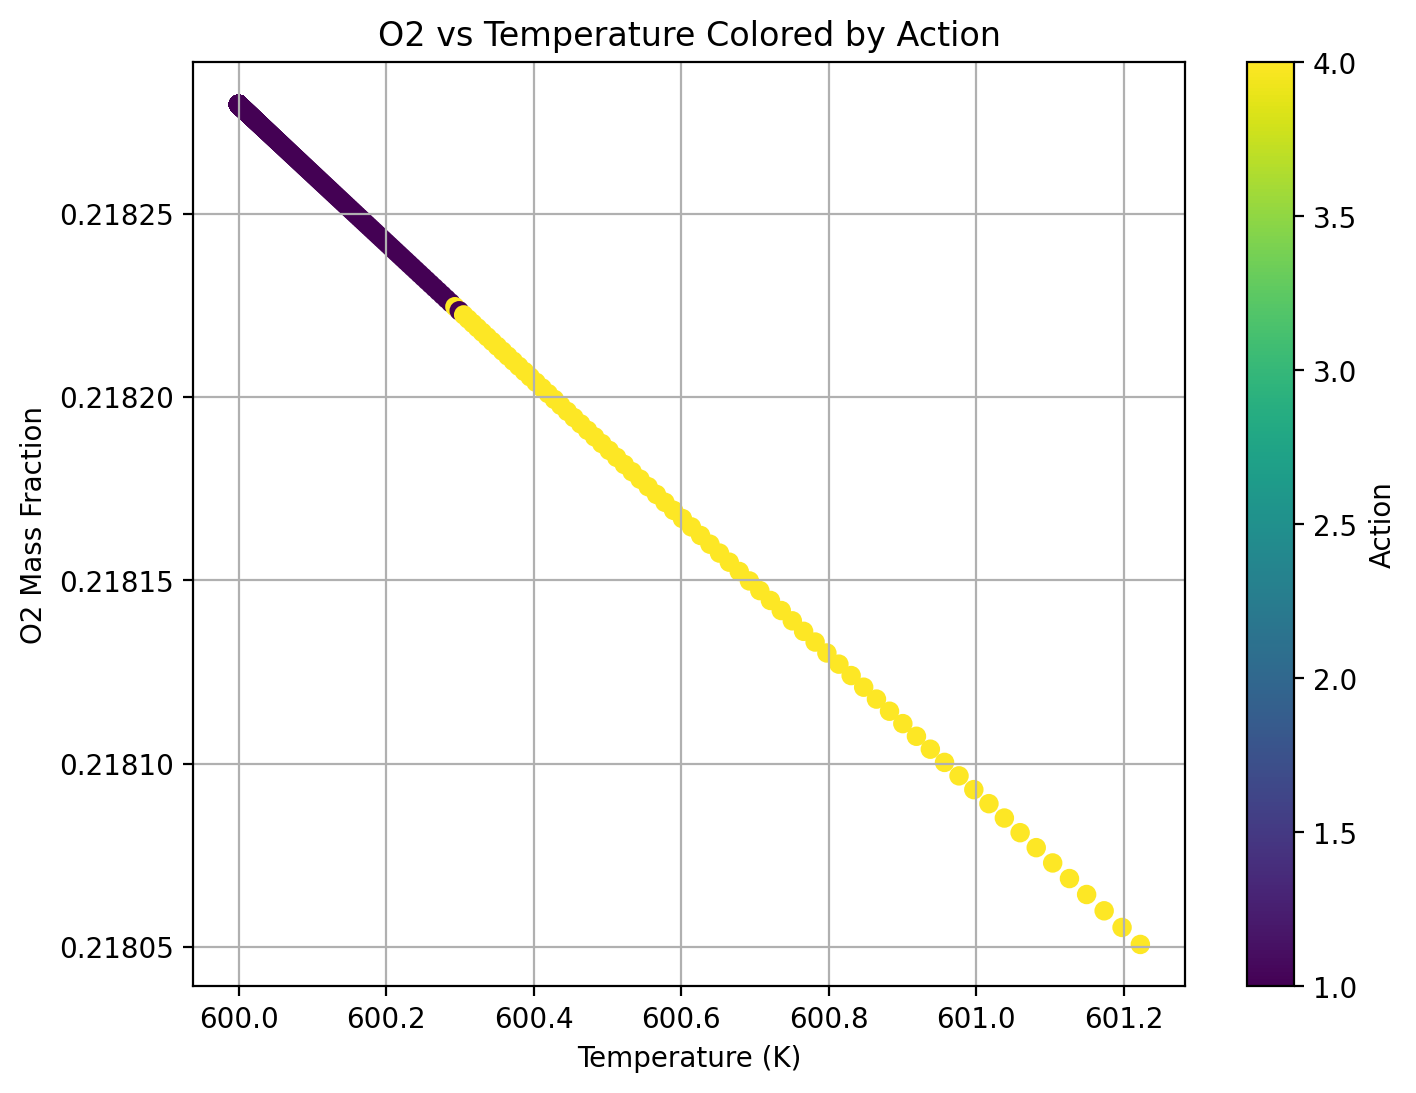

In [193]:
# plot temperature vs h2o scatter plot and color by action
plt.figure(figsize=(8, 6), dpi=200)
plt.scatter(state_action_pair_np[:600, 0], state_action_pair_np[:600, 2], c=state_action_pair_np[:600, 9], cmap='viridis')
plt.colorbar(label='Action')
plt.xlabel('Temperature (K)')
plt.ylabel('O2 Mass Fraction')
plt.title('O2 vs Temperature Colored by Action')
# use log scale for y axis
# plt.yscale('log')
plt.grid(True)
plt.show()


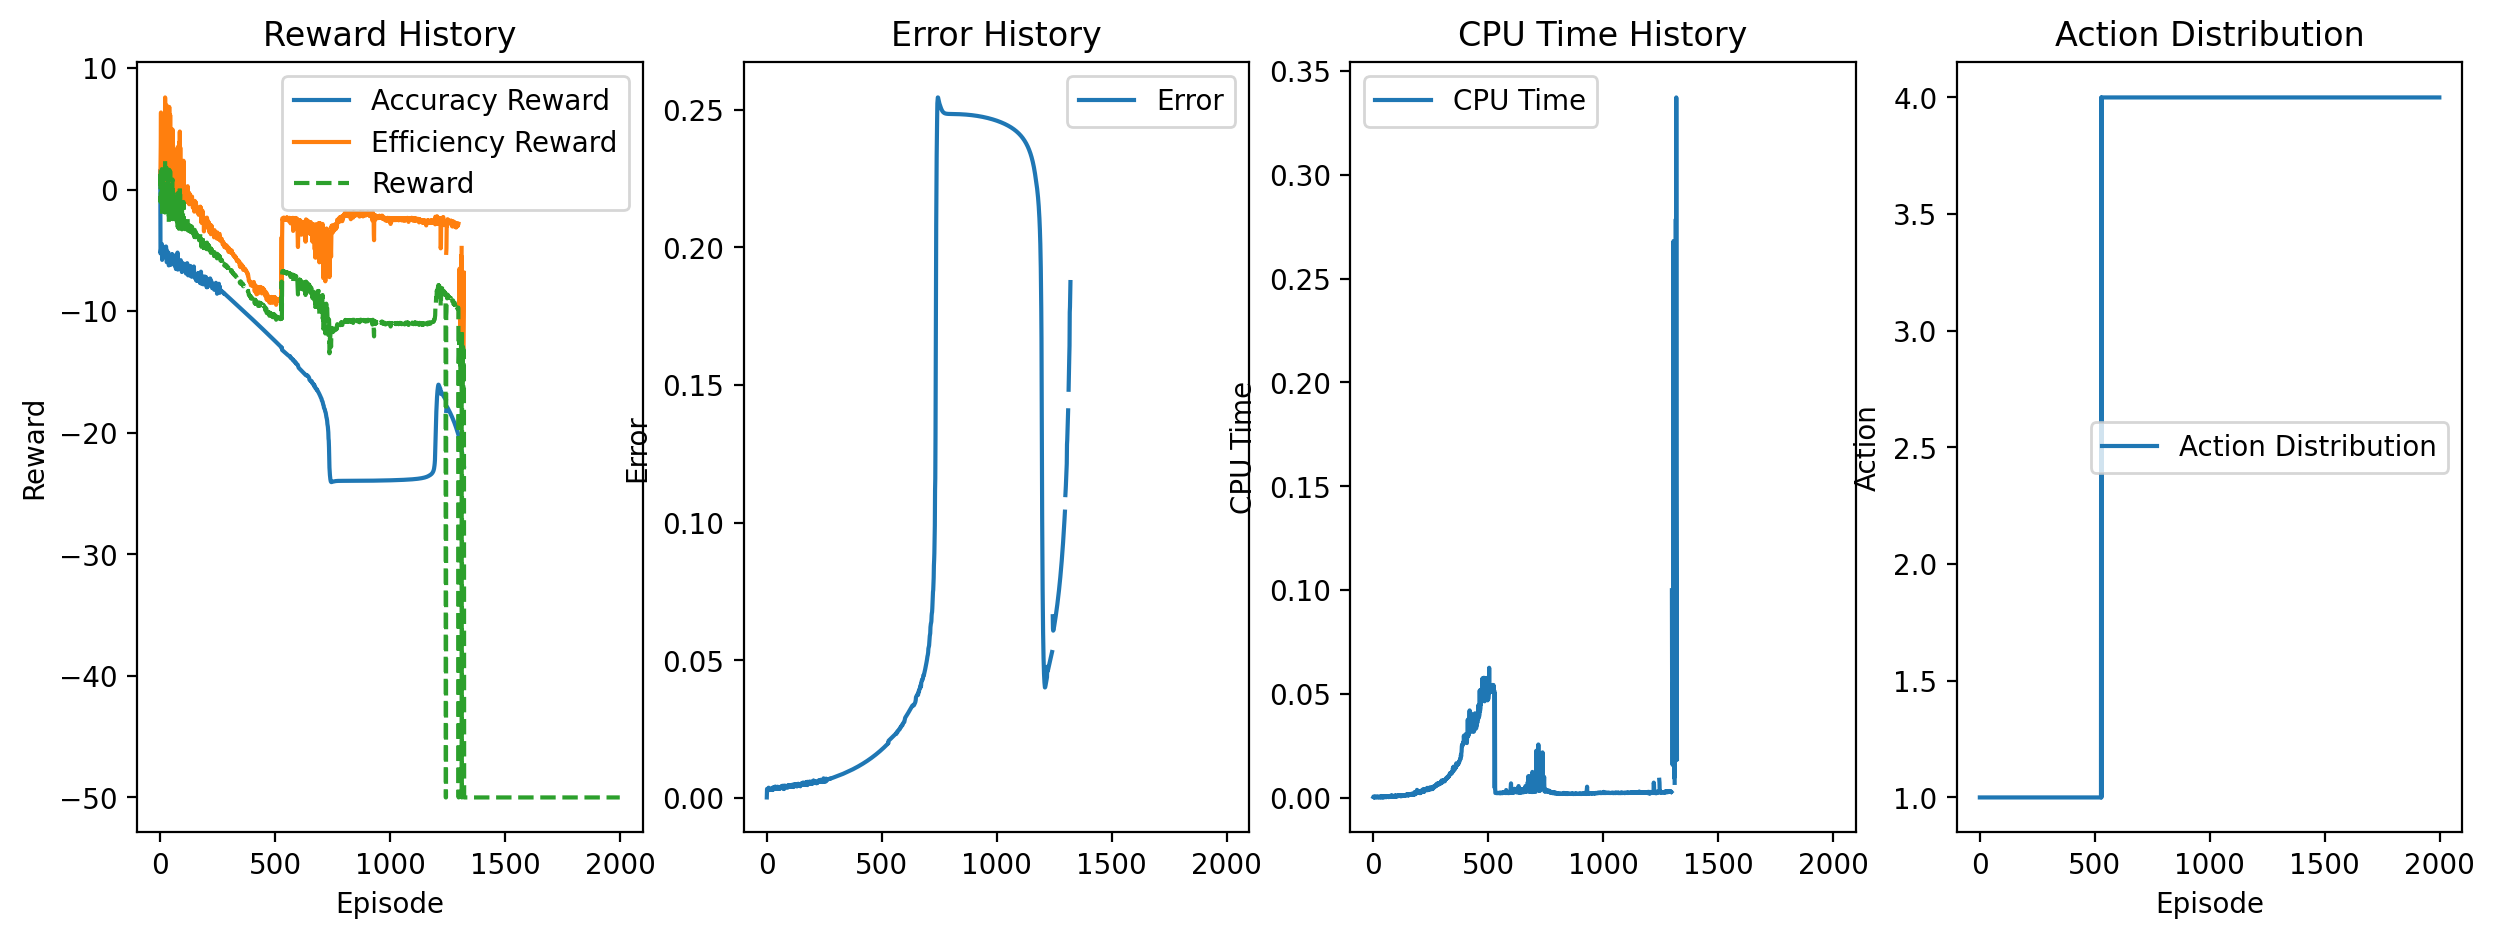

In [194]:
import matplotlib
import matplotlib.pyplot as plt

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(15, 5), sharex=True, dpi=200)

ax1.plot(accuracy_rewards, label='Accuracy Reward')
ax1.plot(efficiency_rewards, label='Efficiency Reward')
ax1.plot(rewards, label='Reward', linestyle='--')
ax2.plot(errors, label='Error')
ax3.plot(cpu_times, label='CPU Time')
ax1.set_xlabel('Episode')
ax1.set_ylabel('Reward')
ax2.set_ylabel('Error')
ax3.set_ylabel('CPU Time')
ax1.set_title('Reward History')
ax2.set_title('Error History')
ax3.set_title('CPU Time History')
ax4.plot(action_distribution_list, label='Action Distribution')
ax4.set_xlabel('Episode')
ax4.set_ylabel('Action')
ax4.set_title('Action Distribution')
ax1.legend()
ax2.legend()
ax3.legend()
ax4.legend()
plt.savefig('reward_history1.png')
plt.show()


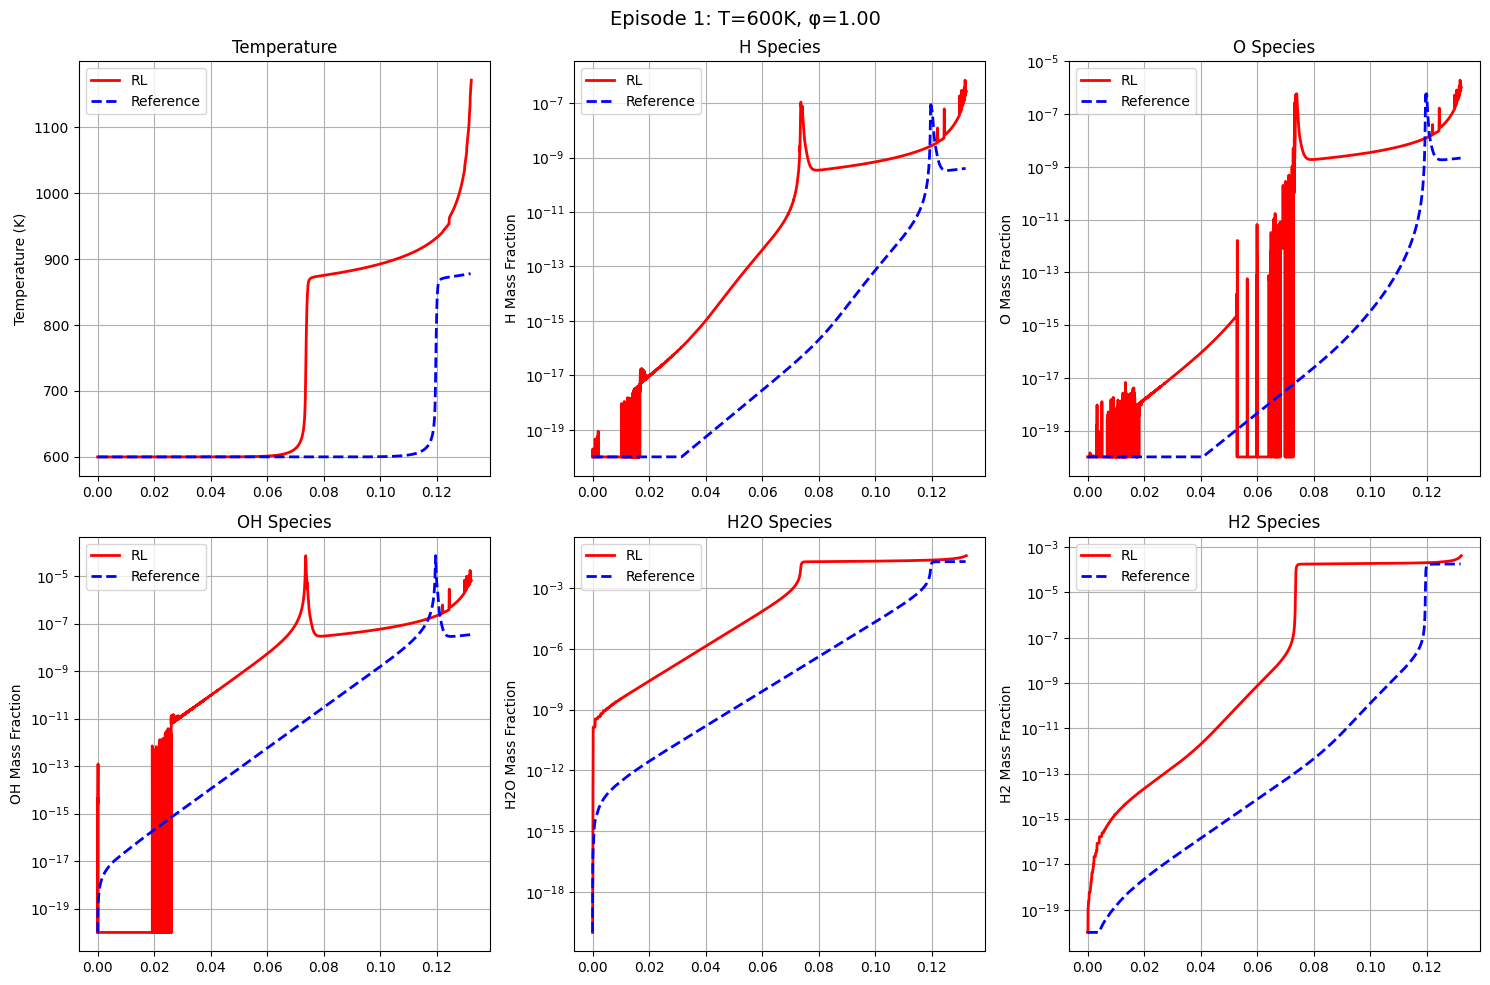

In [195]:
plot_trajectory_comparison([env.get_trajectory_data()])

In [ ]:
# model = PPO("MlpPolicy", env, verbose=1, learning_rate=3e-4, 
#                 n_steps=2048, batch_size=64, n_epochs=10)


# model = model.load("integrator_switching_ppo")
# if __name__ == "__main__":
#     mechanism_file='large_mechanism/n-dodecane.yaml'      
#     temp_range=(300, 1200)
#     phi_range=(0.1, 2.0)
#     time_range=(1e-3, 2e-2)
#     timestep=1e-6
#     super_steps=100
#     fuel='nc12h26'
#     oxidizer='O2:0.21, N2:0.79'
#     pressure=ct.one_atm
#     env = IntegratorSwitchingEnv(mechanism_file=mechanism_file, temp_range=temp_range, 
#                                 phi_range=phi_range, time_range=time_range, timestep=timestep, 
#                                 super_steps=super_steps, fuel=fuel, oxidizer=oxidizer, pressure=pressure)mechanism_file='large_mechanism/n-dodecane.yaml'      
#     temp_range=(300, 1200)
#     phi_range=(0.1, 2.0)
#     time_range=(1e-3, 2e-2)
#     timestep=1e-6
#     super_steps=100
#     fuel='nc12h26'
#     oxidizer='O2:0.21, N2:0.79'
#     pressure=ct.one_atm
#     env = IntegratorSwitchingEnv(mechanism_file=mechanism_file, temp_range=temp_range, 
#                                 phi_range=phi_range, time_range=time_range, timestep=timestep, 
#                                 super_steps=super_steps, fuel=fuel, oxidizer=oxidizer, pressure=pressure)
#         # Train agent
#     model, env, callback = train_rl_agent()
    
#     # Plot training progress
#     plt.figure(figsize=(10, 5), dpi=200)
#     plt.plot(callback.episode_rewards)
#     plt.title('Training Progress')
#     plt.xlabel('Episode')
#     plt.ylabel('Total Reward')
#     plt.grid(True)
#     plt.show()
    
#     # Evaluate agent and collect trajectories
#     episode_rewards, action_counts, trajectories = evaluate_agent(model, env)
    
#     # Plot trajectory comparisons
#     for i in range(min(3, len(trajectories))):  # Plot first 3 episodes
#         plot_trajectory_comparison(trajectories, i)
    
#     # Save model
#     model.save("integrator_switching_ppo")
#     print("Model saved!")